In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

Prediction / Inference While we often spend most of our time focusing on training and testing models, the whole reason we’re doing any of this is to have a model that takes new inputs and produces desired outputs. This will typically involve many attempts to train the best model possible, save that model, and load that saved model to do inference, or prediction. In the case of Fashion MNIST classification, we’d like to load a trained model, show it never-before-seen images, and have it predict the correct classification. To do this, we’ll add a new ​predict​ ​method to the ​Model​ class:

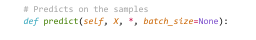

Note that we predict ​X​ with a possible ​batch_size​. This means all predictions, including predictions on just one sample, will still be fed in as a list of samples in the form of a NumPy array, whose first dimension is the list samples, and second is sample data. For example, if we would like to predict on a single image, we still need to create a NumPy array mimicking a list containing a single sample — with a shape of ​(1, 784)​ where ​1​ is this single sample, and ​784​ is the number of features in a sample (pixels per image). Similar to the ​evaluate​ method, we’ll calculate the number of steps we plan to take:

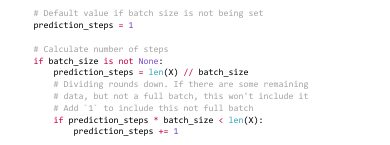

Then create a list that we’ll populate with the predictions:.

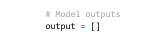

We’ll iterate over the batches, passing the samples for predictions forward through the network, and populating the ​output​ with the predictions:

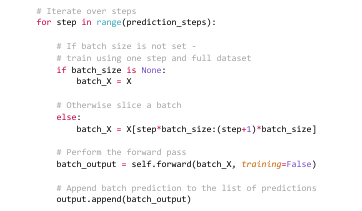

After running this, the ​output​ is a list of batch predictions. Each of them is a NumPy array, a partial result made by predicting on a batch of samples from the input data array. Any applications, or programs, that will make use of the inference output of our models, we expect to simply pass in a list of samples and get back a list of predictions (both in the form of a NumPy array as mentioned before). Since we’re not focused on training, we’re only using batches in prediction to ensure our model can fit into memory, but we’re going to get a return that’s also in batches of predictions. We can see a simple example of this:

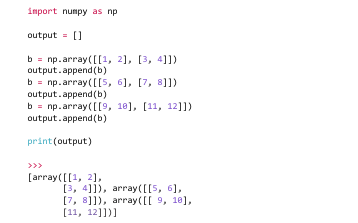

In this example, we see an output with a batch size of 2 and 6 total samples. The output is a list of arrays, with each array housing a batch of predictions. Instead, we want just 1 list of predictions, no more batches. To achieve this, we’re going to use NumPy’s ​vstack​ method:

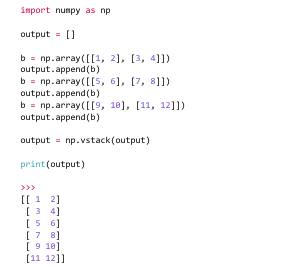

It takes a list of objects and stacks them, if possible, creating a homologous array. This is a preferable form of the return from the ​predict​ method when we pass a list of samples. With plain Python, we might just add to the list each step:

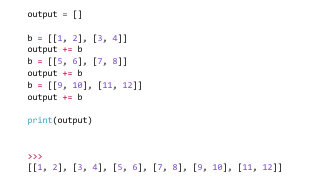

We add results to a list and stack them at the end, instead of appending to the NumPy array each batch to avoid a performance penalty. Unlike plain Python, NumPy is written in ​C​ language and creates data objects in memory differently. That means that there is no easy way of adding data to the existing NumPy array, other than merging two arrays and saving the result as a new array. But this will lead to a performance penalty, since the further in predictions we are, the bigger the resulting array is. The fastest and most optimal way is to append NumPy arrays to a list and stack them vertically at once when we have collected all of the partial results. We’ll add the np.vstack​ to the end of the outputs that we return:


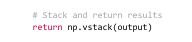

Making our full ​predict​ method:

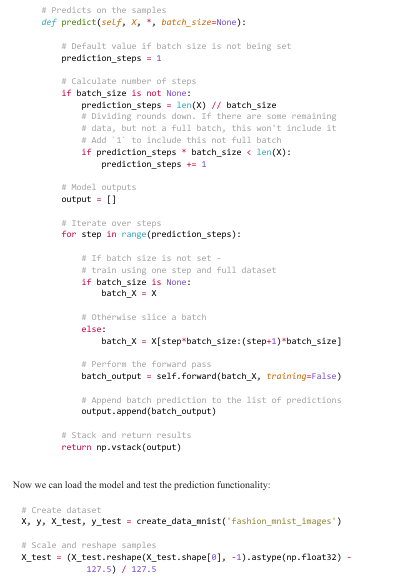

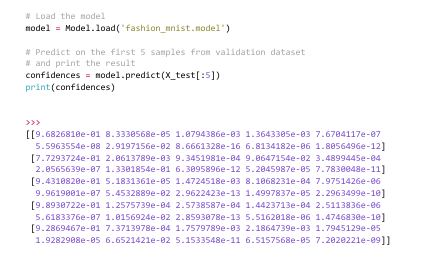

It looks like it’s working! After spending so much time training and finding the best hyperparameters, a common issue people have is actually ​using​ the model. As a reminder, each of the subarrays in the output is a vector of confidences containing a confidence metric per class. The first thing that we need to do in this case is to gather the argmax values of these confidence vectors. Recall that we’re using a softmax classifier, so this neural network is attempting to fit to one-hot vectors, where the correct class is represented by a 1, and the others by 0s. When doing inference, it is unlikely to achieve such a perfect result, but the index associated with the highest value in the output is what we determine the model is predicting; we’re just using the argmax. We could write code to do this, but we’ve already done that in all of the activation function classes, where we added a ​predictions​ method:

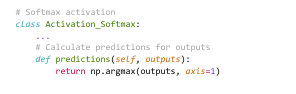


We’ve also set an attribute in our model with the output layer’s activation function, which means we can generically acquire predictions by performing:

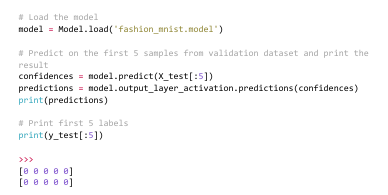

In this case, our model predicted all “class 0,” and our test labels were all class 0 as well. Since shuffling our testing data isn’t essential, we never shuffled them, so they’re going in the original order like our training data was. This explains why all these predictions are 0s. ​ hat class number something is, we want to know ​what​ it is. In this In practice, we don’t care​ w case, class numbers map directly to names, so we add the following dictionary to our code:


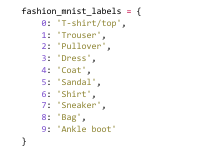

Then we could get the string classification by performing:

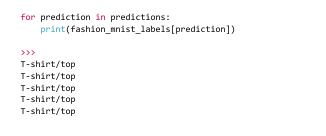

